In [28]:
# import pandas as pd
# 
# def assign_team_numbers_and_update(file1, file2,file3,file4,file5, file6, file7, file8, file9, file10, file11):
# 
#     df1 = pd.read_excel(file1)
#     df2 = pd.read_excel(file2)
#     df3 = pd.read_excel(file3)
#     df4 = pd.read_excel(file4)
#     df5 = pd.read_excel(file5)
#     df6 = pd.read_excel(file6)
#     df7 = pd.read_excel(file7)
#     df8 = pd.read_excel(file8)
#     df9 = pd.read_excel(file9)
#     df10 = pd.read_excel(file10)
#     df11 = pd.read_excel(file11)
#     
# 
#     teams1 = df1['Team'].unique()
#     teams2 = df2['Team'].unique()
#     teams3 = df3['Team'].unique()
#     teams4 = df4['Team'].unique()
#     teams5 = df5['Team'].unique()
#     teams6 = df6['Team'].unique()
#     teams7 = df7['Team'].unique()
#     teams8 = df8['Team'].unique()
#     teams9 = df9['Team'].unique()
#     teams10 = df10['Team'].unique()
#     teams11 = df11['Team'].unique()
#     
#    
#     all_unique_teams = list(set(list(teams1) + list(teams2)+ list(teams3) + list(teams4)+ list(teams5)
#                                +list(teams6) + list(teams7)+ list(teams8) + list(teams9)+ list(teams10)
#                                +list(teams11)))
#     
#     
#     team_numbers = {team: idx+1 for idx, team in enumerate(all_unique_teams)}
#     
#  
#     df1['team identifier'] = df1['Team'].map(team_numbers)
#     df2['team identifier'] = df2['Team'].map(team_numbers)
#     df3['team identifier'] = df3['Team'].map(team_numbers)
#     df4['team identifier'] = df4['Team'].map(team_numbers)
#     df5['team identifier'] = df5['Team'].map(team_numbers)
#     df6['team identifier'] = df6['Team'].map(team_numbers)
#     df7['team identifier'] = df7['Team'].map(team_numbers)
#     df8['team identifier'] = df8['Team'].map(team_numbers)
#     df9['team identifier'] = df9['Team'].map(team_numbers)
#     df10['team identifier'] = df10['Team'].map(team_numbers)
#     df11['team identifier'] = df11['Team'].map(team_numbers)
#  
#     df1.to_excel(file1, index=False)
#     df2.to_excel(file2, index=False)
#     df3.to_excel(file3, index=False)
#     df4.to_excel(file4, index=False)
#     df5.to_excel(file5, index=False)
#     df6.to_excel(file6, index=False)
#     df7.to_excel(file7, index=False)
#     df8.to_excel(file8, index=False)
#     df9.to_excel(file9, index=False)
#     df10.to_excel(file10, index=False)
#     df11.to_excel(file11, index=False)
#     
#     return team_numbers
# 
# team_numbers = assign_team_numbers_and_update("2012_13.xlsx", "2013_14.xlsx","2014_15.xlsx","2015_16.xlsx","2016_17.xlsx",
#                                              "2017_18.xlsx","2018_19.xlsx","2019_20.xlsx","2020_21.xlsx","2021_22.xlsx","2022_23.xlsx")
# print(team_numbers)


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.backend as K
from itertools import combinations


data = pd.read_excel("../My_datasets/2012_13.xlsx")
print(data.head())
def preprocess_data(df, numerical_cols, categorical_cols):
    df = df.copy()

    # Fill missing numerical values with mean
    for col in numerical_cols:
        df[col].fillna(df[col].mean(), inplace=True)

    # Standardize numerical features
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    
    # Fill missing categorical values with mode
    for col in categorical_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)

    # One-hot encode categorical features
    df = pd.get_dummies(df, columns=categorical_cols)

    return df





numerical_cols_data = data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols_data = data.select_dtypes(include=['object']).columns



data_preprocessed = preprocess_data(data, numerical_cols_data, categorical_cols_data)
data_preprocessed['team identifier'] = data_preprocessed.index



pairs = []

labels = []
for team1, team2 in combinations(data_preprocessed.index, 2):
    pairs.append([data_preprocessed.loc[team1].values, data_preprocessed.loc[team2].values])
    if(team1==team2):
        labels.append(1)
    else:
        labels.append(0)

  

    
pairs = np.array(pairs)

labels = np.array(labels)

labels = labels.astype(np.float32)

# print(labels.shape)
# labels_copy = np.copy(labels)
# labels = np.vstack((labels,labels_copy))
# print(labels.shape)

def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)


def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


input_shape = pairs.shape[-1]
base_network = create_base_network(input_shape)

input_a = Input(shape=(input_shape,))
input_b = Input(shape=(input_shape,))


processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

# model = Model([input_a, input_b], distance)


# def contrastive_loss(y_true, y_pred):
#     margin = 5
#     square_pred = K.square(y_pred)
#     margin_square = K.square(K.maximum(margin - y_pred, 0))
#     return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

# # Compile the model
# model.compile(loss=contrastive_loss, optimizer=RMSprop())

# # Train the model
# model.fit([pairs[:, 0], pairs[:, 1]], labels, batch_size=32, epochs=30)

                Team  Total shots  OutOfBoxshots  SixYardBoxShots  \
0  Manchester United          560            191               50   
1    Manchester City          659            245               46   
2            Chelsea          627            294               29   
3            Arsenal          598            243               40   
4          Tottenham          681            369               36   

   PenaltyAreaShots  TotalGoals  SixYardBoxGoals  PenaltyAreaGoals  \
0               319          85               25                46   
1               368          66                9                46   
2               304          74               12                49   
3               315          69               15                47   
4               276          62               13                33   

   OutOfBoxGoals  Total Dribbles  ...  TotalSaves  SixYardBoxSaves  \
0              9             470  ...         105                7   
1              9        

In [4]:

# similarity_scores = model.predict([pairs[:, 0], pairs[:, 1]])

# predicted_wins = {team: 0 for team in data_preprocessed.index}


# for i, (team1, team2) in enumerate(combinations(data_preprocessed.index, 2)):
#     if similarity_scores[i] > 0.5:
#         predicted_wins[team1] += similarity_scores[i]
#     else:
#         predicted_wins[team2] -= similarity_scores[i]


# team_wins = pd.DataFrame(list(map(list, zip(predicted_wins.values()))), index=predicted_wins.keys(), columns=['predicted_wins'])


# rankings = team_wins.sort_values('predicted_wins', ascending=False)

# print(rankings)
# print(similarity_scores.shape)

In [5]:
# from scipy.stats import spearmanr


# actual_rankings = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

# predicted_rankings = rankings.index.tolist()
# print(predicted_rankings)

# accuracy = sum(a == p for a, p in zip(actual_rankings, predicted_rankings)) / len(actual_rankings)
# print(f'Accuracy: {accuracy * 100:.2f}%')

# # # # Compute Spearman's rank correlation
# # correlation, _ = spearmanr(actual_rankings, predicted_rankings)
# # print(f"Spearman's rank correlation: {correlation:.2f}")


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.backend as K
from itertools import combinations
def preprocess_data(df, numerical_cols, categorical_cols):
    df = df.copy()

    # Fill missing numerical values with mean
    for col in numerical_cols:
        df[col].fillna(df[col].mean(), inplace=True)

    # Standardize numerical features
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    
    # Fill missing categorical values with mode
    for col in categorical_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)

    # One-hot encode categorical features
    df = pd.get_dummies(df, columns=categorical_cols)

    return df

def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(33, activation='relu')(x)
    x = Dropout(0.01)(x)
    x = Dense(20, activation='relu')(x)
    x = Dropout(0.01)(x)
    x = Dense(5, activation='relu')(x)
    return Model(input, x)


def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)
def contrastive_loss(y_true, y_pred):
    margin = 5 
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [7]:
# Load the data
data = pd.read_excel("../My_datasets/2012_13.xlsx") 
data_2013_2014 = pd.read_excel("../My_datasets/2013_14.xlsx")
data_2014_2015 = pd.read_excel("../My_datasets/2014_15.xlsx")
data_2015_2016 = pd.read_excel("../My_datasets/2015_16.xlsx")
data_2016_2017 = pd.read_excel("../My_datasets/2016_17.xlsx")
data_2017_2018 = pd.read_excel("../My_datasets/2017_18.xlsx")
data_2018_2019 = pd.read_excel("../My_datasets/2018_19.xlsx")
data_2019_2020 = pd.read_excel("../My_datasets/2019_20.xlsx")
data_2020_2021 = pd.read_excel("../My_datasets/2020_21.xlsx")
data_2021_2022 = pd.read_excel("../My_datasets/2021_22.xlsx")
data_2022_2023 = pd.read_excel("../My_datasets/2022_23.xlsx")
# print(data_2022_2023.shape)
#2012/13
numerical_cols_data = data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols_data = data.select_dtypes(include=['object']).columns
data_preprocessed = preprocess_data(data, numerical_cols_data, categorical_cols_data)
data_preprocessed['team identifier'] = data['team identifier']
#2013/14
numerical_cols_data_2013_2014 = data_2013_2014.select_dtypes(include=['int64', 'float64']).columns
categorical_cols_data_2013_2014 = data_2013_2014.select_dtypes(include=['object']).columns
data_preprocessed_data_2013_2014 = preprocess_data(data_2013_2014, numerical_cols_data_2013_2014, categorical_cols_data_2013_2014)
data_preprocessed_data_2013_2014['team identifier'] = data_2013_2014['team identifier']
#2014/15
numerical_cols_data_2014_2015 = data_2014_2015.select_dtypes(include=['int64', 'float64']).columns
categorical_cols_data_2014_2015 = data_2014_2015.select_dtypes(include=['object']).columns
data_preprocessed_data_2014_2015 = preprocess_data(data_2014_2015, numerical_cols_data_2014_2015, categorical_cols_data_2014_2015)
data_preprocessed_data_2014_2015['team identifier'] = data_2014_2015['team identifier']
#2015/16
numerical_cols_data_2015_2016 = data_2015_2016.select_dtypes(include=['int64', 'float64']).columns
categorical_cols_data_2015_2016 = data_2015_2016.select_dtypes(include=['object']).columns
data_preprocessed_data_2015_2016 = preprocess_data(data_2015_2016, numerical_cols_data_2015_2016, categorical_cols_data_2015_2016)
data_preprocessed_data_2015_2016['team identifier'] = data_2015_2016['team identifier']
#2016/17
numerical_cols_data_2016_2017 = data_2016_2017.select_dtypes(include=['int64', 'float64']).columns
categorical_cols_data_2016_2017 = data_2016_2017.select_dtypes(include=['object']).columns
data_preprocessed_data_2016_2017 = preprocess_data(data_2016_2017, numerical_cols_data_2016_2017, categorical_cols_data_2016_2017)
data_preprocessed_data_2016_2017['team identifier'] = data_2016_2017['team identifier']
#2017/18
numerical_cols_data_2017_2018 = data_2017_2018.select_dtypes(include=['int64', 'float64']).columns
categorical_cols_data_2017_2018 = data_2017_2018.select_dtypes(include=['object']).columns
data_preprocessed_data_2017_2018 = preprocess_data(data_2017_2018, numerical_cols_data_2017_2018, categorical_cols_data_2017_2018)
data_preprocessed_data_2017_2018['team identifier'] = data_2017_2018['team identifier']
#2018/19
numerical_cols_data_2018_2019 = data_2018_2019.select_dtypes(include=['int64', 'float64']).columns
categorical_cols_data_2018_2019 = data_2018_2019.select_dtypes(include=['object']).columns
data_preprocessed_data_2018_2019 = preprocess_data(data_2018_2019, numerical_cols_data_2018_2019, categorical_cols_data_2018_2019)
data_preprocessed_data_2018_2019['team identifier'] = data_2018_2019['team identifier']
#2019/20
numerical_cols_data_2019_2020 = data_2019_2020.select_dtypes(include=['int64', 'float64']).columns
categorical_cols_data_2019_2020 = data_2019_2020.select_dtypes(include=['object']).columns
data_preprocessed_data_2019_2020 = preprocess_data(data_2019_2020, numerical_cols_data_2019_2020, 
                                                   categorical_cols_data_2019_2020)
data_preprocessed_data_2019_2020['team identifier'] = data_2019_2020['team identifier']
#2020/21
numerical_cols_data_2020_2021 = data_2020_2021.select_dtypes(include=['int64', 'float64']).columns
categorical_cols_data_2020_2021 = data_2020_2021.select_dtypes(include=['object']).columns
data_preprocessed_data_2020_2021 = preprocess_data(data_2020_2021, numerical_cols_data_2020_2021, 
                                                   categorical_cols_data_2020_2021)
data_preprocessed_data_2020_2021['team identifier'] = data_2020_2021['team identifier']
#2021/22
numerical_cols_data_2021_2022 = data_2021_2022.select_dtypes(include=['int64', 'float64']).columns
categorical_cols_data_2021_2022 = data_2021_2022.select_dtypes(include=['object']).columns
data_preprocessed_data_2021_2022 = preprocess_data(data_2021_2022, numerical_cols_data_2021_2022, 
                                                   categorical_cols_data_2021_2022)
data_preprocessed_data_2021_2022['team identifier'] = data_2021_2022['team identifier']
#2022/23
numerical_cols_data_2022_2023 = data_2022_2023.select_dtypes(include=['int64', 'float64']).columns
categorical_cols_data_2022_2023 = data_2022_2023.select_dtypes(include=['object']).columns
data_preprocessed_data_2022_2023 = preprocess_data(data_2022_2023, numerical_cols_data_2022_2023, 
                                                   categorical_cols_data_2022_2023)
data_preprocessed_data_2022_2023['team identifier'] = data_2022_2023['team identifier']

# 
# 
# 
# #2012/13
# team_to_rank = {}
# actual_rankings = data_preprocessed['team identifier'].values
# print(actual_rankings)
# for team, rank in zip(data_preprocessed['team identifier'], actual_rankings):
#     team_to_rank[team] = rank
# 
# pairs = []
# labels = []
# 
# for team1, team2 in combinations(data_preprocessed['team identifier'], 2):
#     pairs.append([
#         data_preprocessed[data_preprocessed['team identifier'] == team1].drop('team identifier', axis=1).values[0], 
#         data_preprocessed[data_preprocessed['team identifier'] == team2].drop('team identifier', axis=1).values[0]
#     ])
#     rank_team1 = team_to_rank[team1]
#     rank_team2 = team_to_rank[team2]
#     labels.append(1 if rank_team1 < rank_team2 else 0)
# 
# pairs = np.array(pairs)
# labels = np.array(labels)
# labels = labels.astype(np.float32)
# 
# 
# #2013/14
# team_to_rank = {}
# actual_rankings_2013_14 = data_preprocessed_data_2013_2014['team identifier'].values
# for team, rank in zip(data_preprocessed_data_2013_2014['team identifier'], actual_rankings_2013_14):
#     team_to_rank[team] = rank
# 
# pairs_2013_14 = []
# labels_2013_14 = []
# 
# for team1, team2 in combinations(data_preprocessed_data_2013_2014['team identifier'], 2):
#     pairs_2013_14.append([
#         data_preprocessed_data_2013_2014[data_preprocessed_data_2013_2014['team identifier'] == team1].drop('team identifier', axis=1).values[0], 
#         data_preprocessed_data_2013_2014[data_preprocessed_data_2013_2014['team identifier'] == team2].drop('team identifier', axis=1).values[0]
#     ])
#     rank_team1 = team_to_rank[team1]
#     rank_team2 = team_to_rank[team2]
#     labels_2013_14.append(1 if rank_team1 < rank_team2 else 0)
# 
# pairs_2013_14 = np.array(pairs_2013_14)
# labels_2013_14 = np.array(labels_2013_14)
# labels_2013_14 = labels_2013_14.astype(np.float32)
# 
# 
# 
# 
# #2014/15
# team_to_rank = {}
# actual_rankings_2014_2015 = data_preprocessed_data_2014_2015['team identifier'].values
# for team, rank in zip(data_preprocessed_data_2014_2015['team identifier'], actual_rankings_2014_2015):
#     team_to_rank[team] = rank
# 
# pairs_2014_15 = []
# labels_2014_15 = []
# 
# for team1, team2 in combinations(data_preprocessed_data_2014_2015['team identifier'], 2):
#     pairs_2014_15.append([
#         data_preprocessed_data_2014_2015[data_preprocessed_data_2014_2015['team identifier'] == team1].drop('team identifier', axis=1).values[0], 
#         data_preprocessed_data_2014_2015[data_preprocessed_data_2014_2015['team identifier'] == team2].drop('team identifier', axis=1).values[0]
#     ])
#     rank_team1 = team_to_rank[team1]
#     rank_team2 = team_to_rank[team2]
#     labels_2014_15.append(1 if rank_team1 < rank_team2 else 0)
# 
# pairs_2014_15 = np.array(pairs_2014_15)
# labels_2014_15 = np.array(labels_2014_15)
# labels_2014_15 = labels_2014_15.astype(np.float32)
# print("labels_2014_15: ",labels_2014_15)
# 
# 
# 
# 
# 
# #2015/16
# team_to_rank = {}
# actual_rankings_2015_2016 = data_preprocessed_data_2015_2016['team identifier'].values
# for team, rank in zip(data_preprocessed_data_2015_2016['team identifier'], actual_rankings_2015_2016):
#     team_to_rank[team] = rank
# 
# pairs_2015_16 = []
# labels_2015_16 = []
# 
# for team1, team2 in combinations(data_preprocessed_data_2015_2016['team identifier'], 2):
#     pairs_2015_16.append([
#         data_preprocessed_data_2015_2016[data_preprocessed_data_2015_2016['team identifier'] == team1].drop('team identifier', axis=1).values[0], 
#         data_preprocessed_data_2015_2016[data_preprocessed_data_2015_2016['team identifier'] == team2].drop('team identifier', axis=1).values[0]
#     ])
#     rank_team1 = team_to_rank[team1]
#     rank_team2 = team_to_rank[team2]
#     labels_2015_16.append(1 if rank_team1 < rank_team2 else 0)
# 
# pairs_2015_16 = np.array(pairs_2015_16)
# labels_2015_16 = np.array(labels_2015_16)
# labels_2015_16 = labels_2015_16.astype(np.float32)
# 
# 
# 
# #2016/17
# team_to_rank = {}
# actual_rankings_2016_2017 = data_preprocessed_data_2016_2017['team identifier'].values
# for team, rank in zip(data_preprocessed_data_2016_2017['team identifier'], actual_rankings_2016_2017):
#     team_to_rank[team] = rank
# 
# pairs_2016_17 = []
# labels_2016_17 = []
# 
# for team1, team2 in combinations(data_preprocessed_data_2016_2017['team identifier'], 2):
#     pairs_2016_17.append([
#         data_preprocessed_data_2016_2017[data_preprocessed_data_2016_2017['team identifier'] == team1].drop('team identifier', axis=1).values[0], 
#         data_preprocessed_data_2016_2017[data_preprocessed_data_2016_2017['team identifier'] == team2].drop('team identifier', axis=1).values[0]
#     ])
#     
#     # Checking the rank of the teams
#     rank_team1 = team_to_rank[team1]
#     rank_team2 = team_to_rank[team2]
#     
#     # If team1 is ranked higher than team2, then label should be 1, otherwise 0
#     labels_2016_17.append(1 if rank_team1 < rank_team2 else 0)
# 
# pairs_2016_17 = np.array(pairs_2016_17)
# labels_2016_17 = np.array(labels_2016_17)
# labels_2016_17 = labels_2016_17.astype(np.float32)
# 
# 
# 
# 
# 
# #2017/18
# team_to_rank = {}
# actual_rankings_2017_2018 = data_preprocessed_data_2017_2018['team identifier'].values
# for team, rank in zip(data_preprocessed_data_2017_2018['team identifier'], actual_rankings_2017_2018):
#     team_to_rank[team] = rank
# 
# pairs_2017_18 = []
# labels_2017_18 = []
# 
# for team1, team2 in combinations(data_preprocessed_data_2017_2018['team identifier'], 2):
#     pairs_2017_18.append([
#         data_preprocessed_data_2017_2018[data_preprocessed_data_2017_2018['team identifier'] == team1].drop('team identifier', axis=1).values[0], 
#         data_preprocessed_data_2017_2018[data_preprocessed_data_2017_2018['team identifier'] == team2].drop('team identifier', axis=1).values[0]
#     ])
#     
#     # Checking the rank of the teams
#     rank_team1 = team_to_rank[team1]
#     rank_team2 = team_to_rank[team2]
#     
#     # If team1 is ranked higher than team2, then label should be 1, otherwise 0
#     labels_2017_18.append(1 if rank_team1 < rank_team2 else 0)
# 
# pairs_2017_18 = np.array(pairs_2017_18)
# labels_2017_18 = np.array(labels_2017_18)
# labels_2017_18 = labels_2017_18.astype(np.float32)
# 
# 
# 
# 
# 
# #2018/19
# team_to_rank = {}
# actual_rankings_2018_2019 = data_preprocessed_data_2018_2019['team identifier'].values
# for team, rank in zip(data_preprocessed_data_2018_2019['team identifier'], actual_rankings_2018_2019):
#     team_to_rank[team] = rank
# 
# 
# pairs_2018_19 = []
# labels_2018_19 = []
# 
# for team1, team2 in combinations(data_preprocessed_data_2018_2019['team identifier'], 2):
#     pairs_2018_19.append([
#         data_preprocessed_data_2018_2019[data_preprocessed_data_2018_2019['team identifier'] == team1].drop('team identifier', axis=1).values[0], 
#         data_preprocessed_data_2018_2019[data_preprocessed_data_2018_2019['team identifier'] == team2].drop('team identifier', axis=1).values[0]
#     ])
#     
#     # Checking the rank of the teams
#     rank_team1 = team_to_rank[team1]
#     rank_team2 = team_to_rank[team2]
#     
#     # If team1 is ranked higher than team2, then label should be 1, otherwise 0
#     labels_2018_19.append(1 if rank_team1 < rank_team2 else 0)
# 
# pairs_2018_19 = np.array(pairs_2018_19)
# labels_2018_19 = np.array(labels_2018_19)
# labels_2018_19 = labels_2018_19.astype(np.float32)
# 
# 
# 
# 
# #2019/20
# team_to_rank = {}
# actual_rankings_2019_2020 = data_preprocessed_data_2019_2020['team identifier'].values
# for team, rank in zip(data_preprocessed_data_2019_2020['team identifier'], actual_rankings_2019_2020):
#     team_to_rank[team] = rank
# 
# pairs_2019_20 = []
# labels_2019_20 = []
# 
# for team1, team2 in combinations(data_preprocessed_data_2019_2020['team identifier'], 2):
#     pairs_2019_20.append([
#         data_preprocessed_data_2019_2020[data_preprocessed_data_2019_2020['team identifier'] == team1].drop('team identifier', axis=1).values[0], 
#         data_preprocessed_data_2019_2020[data_preprocessed_data_2019_2020['team identifier'] == team2].drop('team identifier', axis=1).values[0]
#     ])
#     
#     # Checking the rank of the teams
#     rank_team1 = team_to_rank[team1]
#     rank_team2 = team_to_rank[team2]
#     
#     # If team1 is ranked higher than team2, then label should be 1, otherwise 0
#     labels_2019_20.append(1 if rank_team1 < rank_team2 else 0)
# 
# pairs_2019_20 = np.array(pairs_2019_20)
# labels_2019_20 = np.array(labels_2019_20)
# labels_2019_20 = labels_2019_20.astype(np.float32)
# 
# 
# 
# 
# 
# 
# 
# #2020/21
# actual_rankings_2020_2021 =data_preprocessed_data_2020_2021['team identifier'].values
# team_to_rank = {}
# for team, rank in zip(data_preprocessed_data_2020_2021['team identifier'], actual_rankings_2020_2021):
#     team_to_rank[team] = rank
# 
# pairs_2020_21 = []
# labels_2020_21 = []
# 
# for team1, team2 in combinations(data_preprocessed_data_2020_2021['team identifier'], 2):
#     pairs_2020_21.append([
#         data_preprocessed_data_2020_2021[data_preprocessed_data_2020_2021['team identifier'] == team1].drop('team identifier', axis=1).values[0], 
#         data_preprocessed_data_2020_2021[data_preprocessed_data_2020_2021['team identifier'] == team2].drop('team identifier', axis=1).values[0]
#     ])
#     
#     # Checking the rank of the teams
#     rank_team1 = team_to_rank[team1]
#     rank_team2 = team_to_rank[team2]
#     
#     # If team1 is ranked higher than team2, then label should be 1, otherwise 0
#     labels_2020_21.append(1 if rank_team1 < rank_team2 else 0)
# 
# pairs_2020_21 = np.array(pairs_2020_21)
# labels_2020_21 = np.array(labels_2020_21)
# labels_2020_21 = labels_2020_21.astype(np.float32)
# 
# 
# 
# 
# 
# 
# 
# #2021/22
# team_to_rank = {}
# actual_rankings_2021_2022 = data_preprocessed_data_2021_2022['team identifier'].values
# print(actual_rankings_2021_2022)
# for team, rank in zip(data_preprocessed_data_2021_2022['team identifier'], actual_rankings_2021_2022):
#     team_to_rank[team] = rank
# 
# pairs_2021_22 = []
# labels_2021_22 = []
# 
# for team1, team2 in combinations(data_preprocessed_data_2021_2022['team identifier'], 2):
#     pairs_2021_22.append([
#         data_preprocessed_data_2021_2022[data_preprocessed_data_2021_2022['team identifier'] == team1].drop('team identifier', axis=1).values[0], 
#         data_preprocessed_data_2021_2022[data_preprocessed_data_2021_2022['team identifier'] == team2].drop('team identifier', axis=1).values[0]
#     ])
#     
#     # Checking the rank of the teams
#     rank_team1 = team_to_rank[team1]
#     rank_team2 = team_to_rank[team2]
#     
#     # If team1 is ranked higher than team2, then label should be 1, otherwise 0
#     labels_2021_22.append(1 if rank_team1 < rank_team2 else 0)
# 
# pairs_2021_22 = np.array(pairs_2021_22)
# labels_2021_22 = np.array(labels_2021_22)
# labels_2021_22 = labels_2021_22.astype(np.float32)
# 
# 
# 
# 
# 
# combined_pairs_trainingSetOne = np.concatenate((pairs, pairs_2013_14,pairs_2014_15,pairs_2015_16,pairs_2016_17,
#                                                pairs_2017_18), axis=0)
# combined_labels_trainingSetOne = np.concatenate((labels, labels_2013_14,labels_2014_15,labels_2015_16,labels_2016_17,
#                                                 labels_2017_18), axis=0)
# 
# print("pairs trainingsetone: ",combined_pairs_trainingSetOne.shape)


# from creatingPairsForTrainingSetOne import trainingSetOne
# 
# combined_pairs_trainingSetOne, combined_labels_trainingSetOne, combined_pairs_trainingSetOneXGB, combined_team_pairs = trainingSetOne()
# combined_labels_trainingSetOne = np.array(combined_labels_trainingSetOne, dtype=np.float32)
# 
# print("sizeeee: ", combined_pairs_trainingSetOne.shape)
# 
# input_shape = combined_pairs_trainingSetOne.shape[-1]
# base_network = create_base_network(input_shape)
# 
# input_a = Input(shape=(input_shape,))
# input_b = Input(shape=(input_shape,))
# processed_a = base_network(input_a)
# processed_b = base_network(input_b)
# distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
# model = Model([input_a, input_b], distance)
# model.compile(loss=contrastive_loss, optimizer=RMSprop())
# model.fit([combined_pairs_trainingSetOne[:, 0], combined_pairs_trainingSetOne[:, 1]], combined_labels_trainingSetOne
#           , batch_size=30, epochs=50)




In [8]:
# #predicting 2018_19
# similarity_scores = model.predict([combined_pairs_trainingSetOne[:, 0], combined_pairs_trainingSetOne[:, 1]])
# print(similarity_scores)
# # Save similarity scores
# 
# predicted_wins = {team: 0 for team in data_preprocessed_data_2018_2019['team identifier']}
# for i, (team1, team2) in enumerate(combinations(data_preprocessed_data_2018_2019['team identifier'], 2)):
#     if similarity_scores[i] > 1:
#         predicted_wins[team1] += similarity_scores[i]
#     else:
#         predicted_wins[team2] -= similarity_scores[i]
# 
# team_wins = pd.DataFrame(list(map(list, zip(predicted_wins.values()))), index=predicted_wins.keys(), columns=['predicted_wins'])
# rankings = team_wins.sort_values('predicted_wins')
# 
# print(team_wins)


In [9]:
# from scipy.stats import spearmanr
# from math import log2
# import numpy as np
# from scipy.stats import spearmanr
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# 
# actual_rankings = [11,
# 8,
# 3,
# 14,
# 30,
# 22,
# 7,
# 5,
# 15,
# 27,
# 19,
# 12,
# 6,
# 2,
# 1,
# 16,
# 23,
# 29,
# 25,
# 9
# 
# ]
# print(actual_rankings)
# predicted_rankings = rankings.index.tolist()
# print(predicted_rankings)
# 
# 
# 
# correlation, _ = spearmanr(actual_rankings, predicted_rankings)
# print(f"Spearman's rank correlation: {correlation:.2f}")
# 
# 
# 
# count_matches = 0
# for a, p in zip(actual_rankings, predicted_rankings):
#     if a == p:
#         count_matches += 1
# 
# accuracy = count_matches / len(actual_rankings)
# print(f'Accuracy: {accuracy * 100:.2f}%')
# 
# relevance_scores = {}
# for rank, team in enumerate(actual_rankings):
#     relevance_scores[team] = 19 - rank
# 
# def dcg_at_k(predicted_ranks, k):
#     dcg = 0
#     for idx, team in enumerate(predicted_ranks[:k]):
#         dcg += (2**relevance_scores[team] - 1) / log2(idx + 2)
#     return dcg
# 
# def ndcg_at_k(predicted_ranks, k):
#     best_dcg = dcg_at_k(sorted(actual_rankings, key=lambda x: relevance_scores[x], reverse=True), k)
#     actual_dcg = dcg_at_k(predicted_ranks, k)
#     return actual_dcg / best_dcg
# 
# 
# 
#         
# k = 20
# def compute_relevance(predicted_rankings, actual_rankings):
#     """Compute continuous relevance values based on rank difference."""
#     relevance = []
#     for predicted_team in predicted_rankings:
#         predicted_rank = predicted_rankings.index(predicted_team)
#         actual_rank = actual_rankings.index(predicted_team)
#         # The relevance is inversely proportional to rank difference
#         rel = 1 / (abs(predicted_rank - actual_rank) + 1)
#         relevance.append(rel)
#     return relevance
# 
# def average_precision_from_relevance(relevance):
#     """Compute Average Precision (AP) from relevance values."""
#     precision_k = [sum(relevance[:k+1]) / (k+1) for k in range(len(relevance))]
#     return sum(precision_k) / len(precision_k)
# 
# # Compute relevance values
# relevance_values_continuous = compute_relevance(predicted_rankings, actual_rankings)
# 
# # Compute MAP
# map_value = average_precision_from_relevance(relevance_values_continuous)
# print(f'NDCG@{k}: {ndcg_at_k(predicted_rankings, k):.2f}')
# 
# print(f'MAP: {map_value:.2f}')


In [15]:
# #2018/19
# from creatingPairsForTrainingSetOne import trainingSetOne
# 
# with open('../SNN_Only/SNN_Only_similarity_scoresTrainingSetOne.txt', 'r') as f:
#     similarity_scoresTrainingSetOne = [float(line.strip()[1:-1]) for line in f.readlines()]
# print(similarity_scoresTrainingSetOne)
# predicted_wins = {team: 0 for team in data_preprocessed_data_2018_2019['team identifier']}
# for i, (team1, team2) in enumerate(combinations(data_preprocessed_data_2018_2019['team identifier'], 2)):
#     if similarity_scoresTrainingSetOne[i] > 1:
#         predicted_wins[team1] += similarity_scoresTrainingSetOne[i]
#     else:
#         predicted_wins[team2] -= similarity_scoresTrainingSetOne[i]
# 
# team_wins = pd.DataFrame(list(map(list, zip(predicted_wins.values()))), index=predicted_wins.keys(), columns=['predicted_wins'])
# rankings = team_wins.sort_values('predicted_wins', ascending=False)
# 
# print(rankings)

[2.6397004, 2.7232544, 1.2376655, 2.42707, 3.4651742, 3.1095893, 2.50154, 1.7386013, 1.7771798, 1.8686472, 2.8043222, 1.7001058, 3.8736184, 1.7686601, 5.5067134, 3.7087095, 4.844019, 4.6353745, 4.485068, 0.90183455, 3.3881676, 0.8242869, 1.3835372, 0.89032423, 0.64281553, 1.1821139, 1.069642, 1.0497363, 1.7062945, 1.1044009, 2.1157558, 1.0644624, 3.9299307, 1.8859193, 3.2020345, 4.662688, 2.7686467, 3.4407063, 1.6399722, 0.766194, 0.45064518, 1.3128653, 1.7710878, 1.6222357, 1.6137532, 1.6322579, 1.5209768, 1.5504328, 1.4751906, 3.2562034, 1.2561055, 2.5588005, 3.87392, 2.0844338, 3.22806, 4.117305, 3.8104053, 3.2430372, 2.5719473, 2.623681, 2.7473514, 3.3913605, 2.5338016, 4.6251206, 2.6273246, 5.9202523, 4.2327657, 5.2981553, 5.160369, 5.122263, 2.1931143, 1.6960679, 0.6288451, 0.70926917, 0.6583604, 0.59332657, 1.9534324, 0.86161107, 2.7797892, 0.8218703, 4.7453327, 2.7075593, 4.0126762, 5.1601024, 3.524608, 0.49907213, 1.8508638, 2.4539242, 2.317436, 2.3013697, 2.0413713, 2.2404616

In [36]:
import pandas as pd
from creatingPairsForTrainingSetOne import trainingSetOne

# Assuming trainingSetOne function returns the necessary data
combined_pairs_trainingSetOne, combined_labels_trainingSetOne, _, team_pairs = trainingSetOne()

# Reading similarity scores
with open('../SNN_Only/SNN_Only_similarity_scoresTrainingSetOne.txt', 'r') as f:
    similarity_scoresTrainingSetOne = [float(line.strip()[1:-1]) for line in f.readlines()]

# Initialize the dictionary to store predicted wins for all teams
predicted_wins = {str(team): 0 for team_list in team_pairs for team in team_list}  # Flatten the list and convert teams to strings

# Update predicted wins based on similarity scores
for i, team_pair in enumerate(team_pairs):
    team1, team2 = map(str, team_pair)  # Convert teams to strings
    
    # Ensure both teams are in the dictionary
    if team1 not in predicted_wins:
        predicted_wins[team1] = 0
    if team2 not in predicted_wins:
        predicted_wins[team2] = 0
    
    # Update the predicted wins
    if similarity_scoresTrainingSetOne[i] > 1:
        predicted_wins[team1] += similarity_scoresTrainingSetOne[i]
        predicted_wins[team1] += similarity_scoresTrainingSetOne[i]
    else:
        predicted_wins[team2] -= similarity_scoresTrainingSetOne[i]

# Create a DataFrame to display the predicted wins
team_wins = pd.DataFrame(list(predicted_wins.values()), index=predicted_wins.keys(), columns=['predicted_wins'])
rankings = team_wins.sort_values('predicted_wins', ascending=False)

# The list of actual rankings
actual_rankings = [11, 8, 3, 14, 30, 22, 7, 5, 15, 27, 19, 12, 6, 2, 1, 16, 23, 29, 25, 9]

# Filter the DataFrame for the teams in actual_rankings and sort
filtered_rankings = rankings.loc[rankings.index.isin(map(str, actual_rankings))]
sorted_filtered_rankings = filtered_rankings.sort_values('predicted_wins', ascending=False)

# Convert the sorted filtered rankings index to a list of integers
rankings = list(map(int, sorted_filtered_rankings.index.tolist()))
rankings.append(7)
# Print the list of integers
print(rankings)


shape from function:     (1140, 2, 51)
[30, 22, 11, 14, 8, 3, 27, 5, 16, 15, 2, 12, 6, 1, 25, 19, 9, 23, 29, 7]


In [37]:
from scipy.stats import spearmanr
from math import log2
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

actual_rankings = [11,
8,
3,
14,
30,
22,
7,
5,
15,
27,
19,
12,
6,
2,
1,
16,
23,
29,
25,
9

]
print(actual_rankings)
predicted_rankings = rankings
print(predicted_rankings)






count_matches = 0
for a, p in zip(actual_rankings, predicted_rankings):
    if a == p:
        count_matches += 1

accuracy = count_matches / len(actual_rankings)
print(f'Accuracy: {accuracy * 100:.2f}%')

relevance_scores = {}
for rank, team in enumerate(actual_rankings):
    relevance_scores[team] = 19 - rank

def dcg_at_k(predicted_ranks, k):
    dcg = 0
    for idx, team in enumerate(predicted_ranks[:k]):
        dcg += (2**relevance_scores[team] - 1) / log2(idx + 2)
    return dcg

def ndcg_at_k(predicted_ranks, k):
    best_dcg = dcg_at_k(sorted(actual_rankings, key=lambda x: relevance_scores[x], reverse=True), k)
    actual_dcg = dcg_at_k(predicted_ranks, k)
    return actual_dcg / best_dcg





def compute_true_and_false_positives(predicted_rankings, actual_rankings, k):
    """Compute True Positives and False Positives up to rank k."""
    true_positives = 0
    for i in range(k):
        predicted_team = predicted_rankings[i]
        actual_rank = actual_rankings.index(predicted_team)
        if actual_rank < k:
            true_positives += 1
    false_positives = k - true_positives
    return true_positives, false_positives

def average_precision(predicted_rankings, actual_rankings, k=20):
    """Compute Average Precision up to rank k."""
    true_positives, false_positives = compute_true_and_false_positives(predicted_rankings, actual_rankings, k)
    return true_positives / (true_positives + false_positives)

def mean_average_precision(predicted_rankings, actual_rankings, k=20):
    """Compute Mean Average Precision up to rank k."""
    return sum(average_precision(predicted_rankings, actual_rankings, k=i) for i in range(1, k+1)) / k





# Computing mAP
k = 5
map_value = mean_average_precision(predicted_rankings, actual_rankings, k)
# print(f'DCG@{k}: {dcg_at_k(predicted_ranks_array, k):.2f}')
print(f'NDCG@{k}: {ndcg_at_k(predicted_rankings, k):.2f}')
print(f"Mean Average Precision (up to rank {k}): {map_value:.2f}")


k = 10
map_value = mean_average_precision(predicted_rankings, actual_rankings, k)
# print(f'DCG@{k}: {dcg_at_k(predicted_ranks_array, k):.2f}')
print(f'NDCG@{k}: {ndcg_at_k(predicted_rankings, k):.2f}')
print(f"Mean Average Precision (up to rank {k}): {map_value:.2f}")

k = 15
map_value = mean_average_precision(predicted_rankings, actual_rankings, k)
# print(f'DCG@{k}: {dcg_at_k(predicted_ranks_array, k):.2f}')
print(f'NDCG@{k}: {ndcg_at_k(predicted_rankings, k):.2f}')
print(f"Mean Average Precision (up to rank {k}): {map_value:.2f}")

# Computing mAP
k = 20
map_value = mean_average_precision(predicted_rankings, actual_rankings, k)
# print(f'DCG@{k}: {dcg_at_k(predicted_ranks_array, k):.2f}')
print(f'NDCG@{k}: {ndcg_at_k(predicted_rankings, k):.2f}')
print(f"Mean Average Precision (up to rank {k}): {map_value:.2f}")
 
 

[11, 8, 3, 14, 30, 22, 7, 5, 15, 27, 19, 12, 6, 2, 1, 16, 23, 29, 25, 9]
[30, 22, 11, 14, 8, 3, 27, 5, 16, 15, 2, 12, 6, 1, 25, 19, 9, 23, 29, 7]
Accuracy: 20.00%
NDCG@5: 0.55
Mean Average Precision (up to rank 5): 0.33
NDCG@10: 0.60
Mean Average Precision (up to rank 10): 0.60
NDCG@15: 0.60
Mean Average Precision (up to rank 15): 0.68
NDCG@20: 0.60
Mean Average Precision (up to rank 20): 0.75


In [66]:
# #2019/20
# 
# with open('../SNN_Only/SNN_Only_similarity_scoresTrainingSetTwo.txt', 'r') as f:
#     similarity_scoresTrainingSetOne = [float(line.strip()[1:-1]) for line in f.readlines()]
# print(similarity_scoresTrainingSetOne)
# predicted_wins = {team: 0 for team in data_preprocessed_data_2019_2020['team identifier']}
# for i, (team1, team2) in enumerate(combinations(data_preprocessed_data_2019_2020['team identifier'], 2)):
#     if similarity_scoresTrainingSetOne[i] > 1:
#         predicted_wins[team1] += similarity_scoresTrainingSetOne[i]
#     else:
#         predicted_wins[team2] -= similarity_scoresTrainingSetOne[i]
# 
# team_wins = pd.DataFrame(list(map(list, zip(predicted_wins.values()))), index=predicted_wins.keys(), columns=['predicted_wins'])
# rankings = team_wins.sort_values('predicted_wins', ascending=False)
# 
# print(rankings)

In [46]:
import pandas as pd
from creatingPairsForTrainingSetTwo import trainingSetOne

# Assuming trainingSetOne function returns the necessary data
combined_pairs_trainingSetOne, combined_labels_trainingSetOne, _, team_pairs = trainingSetOne()

# Reading similarity scores
with open('../SNN_Only/SNN_Only_similarity_scoresTrainingSetTwo.txt', 'r') as f:
    similarity_scoresTrainingSetOne = [float(line.strip()[1:-1]) for line in f.readlines()]
print(len(team_pairs))  # This should match the length of similarity_scoresTrainingSetOne
print(len(similarity_scoresTrainingSetOne))

# Initialize the dictionary to store predicted wins for all teams
predicted_wins = {str(team): 0 for team_list in team_pairs for team in team_list}  # Flatten the list and convert teams to strings

# Update predicted wins based on similarity scores
for i, team_pair in enumerate(team_pairs):
    team1, team2 = map(str, team_pair)  # Convert teams to strings
    
    # Ensure both teams are in the dictionary
    if team1 not in predicted_wins:
        predicted_wins[team1] = 0
    if team2 not in predicted_wins:
        predicted_wins[team2] = 0
    
    # Update the predicted wins
    if similarity_scoresTrainingSetOne[i] > 1:
        predicted_wins[team1] += similarity_scoresTrainingSetOne[i]
        predicted_wins[team1] += similarity_scoresTrainingSetOne[i]
    else:
        predicted_wins[team2] -= similarity_scoresTrainingSetOne[i]

# Create a DataFrame to display the predicted wins
team_wins = pd.DataFrame(list(predicted_wins.values()), index=predicted_wins.keys(), columns=['predicted_wins'])
rankings = team_wins.sort_values('predicted_wins', ascending=False)

# The list of actual rankings
actual_rankings = [8,
11,
22,
3,
15,
14,
7,
30,
10,
1,
16,
5,
6,
12,
23,
27,
35,
2,
19,
28

]

# Filter the DataFrame for the teams in actual_rankings and sort
filtered_rankings = rankings.loc[rankings.index.isin(map(str, actual_rankings))]
sorted_filtered_rankings = filtered_rankings.sort_values('predicted_wins', ascending=False)

# Convert the sorted filtered rankings index to a list of integers
rankings = list(map(int, sorted_filtered_rankings.index.tolist()))
# Print the list of integers

print(rankings)


shape from function:     (1330, 2, 51)
1330
1330
[30, 22, 11, 14, 8, 3, 27, 5, 16, 15, 2, 12, 6, 1, 35, 19, 28, 7, 23]


In [49]:
from xml.etree.ElementPath import ops
from pandas.core.ops import array_ops
from scipy.stats import spearmanr
from math import log2
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

actual_rankings = [8,
11,
22,
3,
15,
14,
7,
30,
10,
1,
16,
5,
6,
12,
23,
27,
35,
2,
19,
28

]
print(actual_rankings)
rankings.append(27)
predicted_rankings = rankings
print(predicted_rankings)




count_matches = 0
for a, p in zip(actual_rankings, predicted_rankings):
    if a == p:
        count_matches += 1

accuracy = count_matches / len(actual_rankings)
print(f'Accuracy: {accuracy * 100:.2f}%')

relevance_scores = {}
for rank, team in enumerate(actual_rankings):
    relevance_scores[team] = 19 - rank

def dcg_at_k(predicted_ranks, k):
    dcg = 0
    for idx, team in enumerate(predicted_ranks[:k]):
        dcg += (2**relevance_scores[team] - 1) / log2(idx + 2)
    return dcg

def ndcg_at_k(predicted_ranks, k):
    best_dcg = dcg_at_k(sorted(actual_rankings, key=lambda x: relevance_scores[x], reverse=True), k)
    actual_dcg = dcg_at_k(predicted_ranks, k)
    return actual_dcg / best_dcg







def compute_true_and_false_positives(predicted_rankings, actual_rankings, k):
    """Compute True Positives and False Positives up to rank k."""
    true_positives = 0
    for i in range(k):
        predicted_team = predicted_rankings[i]
        actual_rank = actual_rankings.index(predicted_team)
        if actual_rank < k:
            true_positives += 1
    false_positives = k - true_positives
    return true_positives, false_positives

def average_precision(predicted_rankings, actual_rankings, k=20):
    """Compute Average Precision up to rank k."""
    true_positives, false_positives = compute_true_and_false_positives(predicted_rankings, actual_rankings, k)
    return true_positives / (true_positives + false_positives)

def mean_average_precision(predicted_rankings, actual_rankings, k=20):
    """Compute Mean Average Precision up to rank k."""
    return sum(average_precision(predicted_rankings, actual_rankings, k=i) for i in range(1, k+1)) / k





# Computing mAP
k = 5
map_value = mean_average_precision(predicted_rankings, actual_rankings, k)
# print(f'DCG@{k}: {dcg_at_k(predicted_ranks_array, k):.2f}')
print(f'NDCG@{k}: {ndcg_at_k(predicted_rankings, k):.2f}')
print(f"Mean Average Precision (up to rank {k}): {map_value:.2f}")


k = 10
map_value = mean_average_precision(predicted_rankings, actual_rankings, k)
# print(f'DCG@{k}: {dcg_at_k(predicted_ranks_array, k):.2f}')
print(f'NDCG@{k}: {ndcg_at_k(predicted_rankings, k):.2f}')
print(f"Mean Average Precision (up to rank {k}): {map_value:.2f}")

k = 15
map_value = mean_average_precision(predicted_rankings, actual_rankings, k)
# print(f'DCG@{k}: {dcg_at_k(predicted_ranks_array, k):.2f}')
print(f'NDCG@{k}: {ndcg_at_k(predicted_rankings, k):.2f}')
print(f"Mean Average Precision (up to rank {k}): {map_value:.2f}")

# Computing mAP
k = 20
map_value = mean_average_precision(predicted_rankings, actual_rankings, k)
# print(f'DCG@{k}: {dcg_at_k(predicted_ranks_array, k):.2f}')
print(f'NDCG@{k}: {ndcg_at_k(predicted_rankings, k):.2f}')
print(f"Mean Average Precision (up to rank {k}): {map_value:.2f}")
 
 

[8, 11, 22, 3, 15, 14, 7, 30, 10, 1, 16, 5, 6, 12, 23, 27, 35, 2, 19, 28]
[30, 22, 11, 14, 8, 3, 27, 5, 16, 15, 2, 12, 6, 1, 35, 19, 28, 7, 23, 27]
Accuracy: 5.00%
NDCG@5: 0.54
Mean Average Precision (up to rank 5): 0.35
NDCG@10: 0.57
Mean Average Precision (up to rank 10): 0.54
NDCG@15: 0.57
Mean Average Precision (up to rank 15): 0.62
NDCG@20: 0.57
Mean Average Precision (up to rank 20): 0.69


In [50]:
# #2020/2021
# 
# with open('../SNN_Only/SNN_Only_similarity_scoresTrainingSetThree.txt', 'r') as f:
#     similarity_scoresTrainingSetOne = [float(line.strip()[1:-1]) for line in f.readlines()]
# print(similarity_scoresTrainingSetOne)
# predicted_wins = {team: 0 for team in data_preprocessed_data_2020_2021['team identifier']}
# for i, (team1, team2) in enumerate(combinations(data_preprocessed_data_2020_2021['team identifier'], 2)):
#     if similarity_scoresTrainingSetOne[i] > 1:
#         predicted_wins[team1] += similarity_scoresTrainingSetOne[i]
#     else:
#         predicted_wins[team2] -= similarity_scoresTrainingSetOne[i]
# 
# team_wins = pd.DataFrame(list(map(list, zip(predicted_wins.values()))), index=predicted_wins.keys(), columns=['predicted_wins'])
# rankings = team_wins.sort_values('predicted_wins', ascending=False)
# 
# print(rankings)


In [51]:
import pandas as pd
from creatingPairsForTrainingSetThree import trainingSetOne

# Assuming trainingSetOne function returns the necessary data
combined_pairs_trainingSetOne, combined_labels_trainingSetOne, _, team_pairs = trainingSetOne()

# Reading similarity scores
with open('../SNN_Only/SNN_Only_similarity_scoresTrainingSetThree.txt', 'r') as f:
    similarity_scoresTrainingSetOne = [float(line.strip()[1:-1]) for line in f.readlines()]
print(len(team_pairs))  # This should match the length of similarity_scoresTrainingSetOne
print(len(similarity_scoresTrainingSetOne))

# Initialize the dictionary to store predicted wins for all teams
predicted_wins = {str(team): 0 for team_list in team_pairs for team in team_list}  # Flatten the list and convert teams to strings

# Update predicted wins based on similarity scores
for i, team_pair in enumerate(team_pairs):
    team1, team2 = map(str, team_pair)  # Convert teams to strings
    
    # Ensure both teams are in the dictionary
    if team1 not in predicted_wins:
        predicted_wins[team1] = 0
    if team2 not in predicted_wins:
        predicted_wins[team2] = 0
    
    # Update the predicted wins
    if similarity_scoresTrainingSetOne[i] > 1:
        predicted_wins[team1] += similarity_scoresTrainingSetOne[i]
        predicted_wins[team1] += similarity_scoresTrainingSetOne[i]
    else:
        predicted_wins[team2] -= similarity_scoresTrainingSetOne[i]

# Create a DataFrame to display the predicted wins
team_wins = pd.DataFrame(list(predicted_wins.values()), index=predicted_wins.keys(), columns=['predicted_wins'])
rankings = team_wins.sort_values('predicted_wins', ascending=False)

# The list of actual rankings
actual_rankings =[11,
22,
8,
3,
15,
27,
14,
30,
18,
5,
35,
6,
7,
12,
16,
23,
1,
25,
21,
10

]

# Filter the DataFrame for the teams in actual_rankings and sort
filtered_rankings = rankings.loc[rankings.index.isin(map(str, actual_rankings))]
sorted_filtered_rankings = filtered_rankings.sort_values('predicted_wins', ascending=False)

# Convert the sorted filtered rankings index to a list of integers
rankings = list(map(int, sorted_filtered_rankings.index.tolist()))
# Print the list of integers

print(rankings)


shape from function:     (1520, 2, 51)
1520
1520
[30, 22, 11, 14, 8, 3, 27, 5, 15, 16, 1, 12, 21, 6, 35, 7, 25, 10, 23]


In [54]:
from scipy.stats import spearmanr
from math import log2
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

actual_rankings = [11,
22,
8,
3,
15,
27,
14,
30,
18,
5,
35,
6,
7,
12,
16,
23,
1,
25,
21,
10

]
print(actual_rankings)
rankings.append(14)
predicted_rankings = rankings
print(predicted_rankings)



count_matches = 0
for a, p in zip(actual_rankings, predicted_rankings):
    if a == p:
        count_matches += 1

accuracy = count_matches / len(actual_rankings)
print(f'Accuracy: {accuracy * 100:.2f}%')

relevance_scores = {}
for rank, team in enumerate(actual_rankings):
    relevance_scores[team] = 19 - rank

def dcg_at_k(predicted_ranks, k):
    dcg = 0
    for idx, team in enumerate(predicted_ranks[:k]):
        dcg += (2**relevance_scores[team] - 1) / log2(idx + 2)
    return dcg

def ndcg_at_k(predicted_ranks, k):
    best_dcg = dcg_at_k(sorted(actual_rankings, key=lambda x: relevance_scores[x], reverse=True), k)
    actual_dcg = dcg_at_k(predicted_ranks, k)
    return actual_dcg / best_dcg






# Computing mAP
k = 5
map_value = mean_average_precision(predicted_rankings, actual_rankings, k)
# print(f'DCG@{k}: {dcg_at_k(predicted_ranks_array, k):.2f}')
print(f'NDCG@{k}: {ndcg_at_k(predicted_rankings, k):.2f}')
print(f"Mean Average Precision (up to rank {k}): {map_value:.2f}")


k = 10
map_value = mean_average_precision(predicted_rankings, actual_rankings, k)
# print(f'DCG@{k}: {dcg_at_k(predicted_ranks_array, k):.2f}')
print(f'NDCG@{k}: {ndcg_at_k(predicted_rankings, k):.2f}')
print(f"Mean Average Precision (up to rank {k}): {map_value:.2f}")

k = 15
map_value = mean_average_precision(predicted_rankings, actual_rankings, k)
# print(f'DCG@{k}: {dcg_at_k(predicted_ranks_array, k):.2f}')
print(f'NDCG@{k}: {ndcg_at_k(predicted_rankings, k):.2f}')
print(f"Mean Average Precision (up to rank {k}): {map_value:.2f}")

# Computing mAP
k = 20
map_value = mean_average_precision(predicted_rankings, actual_rankings, k)
# print(f'DCG@{k}: {dcg_at_k(predicted_ranks_array, k):.2f}')
print(f'NDCG@{k}: {ndcg_at_k(predicted_rankings, k):.2f}')
print(f"Mean Average Precision (up to rank {k}): {map_value:.2f}")
 

[11, 22, 8, 3, 15, 27, 14, 30, 18, 5, 35, 6, 7, 12, 16, 23, 1, 25, 21, 10]
[30, 22, 11, 14, 8, 3, 27, 5, 15, 16, 1, 12, 21, 6, 35, 7, 25, 10, 23, 14]
Accuracy: 5.00%
NDCG@5: 0.61
Mean Average Precision (up to rank 5): 0.45
NDCG@10: 0.65
Mean Average Precision (up to rank 10): 0.65
NDCG@15: 0.65
Mean Average Precision (up to rank 15): 0.69
NDCG@20: 0.65
Mean Average Precision (up to rank 20): 0.75


In [55]:
# #predicting 2021_22
# 
# with open('../SNN_Only/SNN_Only_similarity_scoresTrainingSetFour.txt', 'r') as f:
#     similarity_scoresTrainingSetOne = [float(line.strip()[1:-1]) for line in f.readlines()]
# print(similarity_scoresTrainingSetOne)
# predicted_wins = {team: 0 for team in data_preprocessed_data_2021_2022['team identifier']}
# for i, (team1, team2) in enumerate(combinations(data_preprocessed_data_2021_2022['team identifier'], 2)):
#     if similarity_scoresTrainingSetOne[i] > 1:
#         predicted_wins[team1] += similarity_scoresTrainingSetOne[i]
#     else:
#         predicted_wins[team2] -= similarity_scoresTrainingSetOne[i]
# 
# team_wins = pd.DataFrame(list(map(list, zip(predicted_wins.values()))), index=predicted_wins.keys(), columns=['predicted_wins'])
# rankings = team_wins.sort_values('predicted_wins', ascending=False)
# 
# print(rankings)

In [56]:
import pandas as pd
from creatingPairsForTrainingSetFour import trainingSetOne

# Assuming trainingSetOne function returns the necessary data
combined_pairs_trainingSetOne, combined_labels_trainingSetOne, _, team_pairs = trainingSetOne()

# Reading similarity scores
with open('../SNN_Only/SNN_Only_similarity_scoresTrainingSetFour.txt', 'r') as f:
    similarity_scoresTrainingSetOne = [float(line.strip()[1:-1]) for line in f.readlines()]
print(len(team_pairs))  # This should match the length of similarity_scoresTrainingSetOne
print(len(similarity_scoresTrainingSetOne))

# Initialize the dictionary to store predicted wins for all teams
predicted_wins = {str(team): 0 for team_list in team_pairs for team in team_list}  # Flatten the list and convert teams to strings

# Update predicted wins based on similarity scores
for i, team_pair in enumerate(team_pairs):
    team1, team2 = map(str, team_pair)  # Convert teams to strings
    
    # Ensure both teams are in the dictionary
    if team1 not in predicted_wins:
        predicted_wins[team1] = 0
    if team2 not in predicted_wins:
        predicted_wins[team2] = 0
    
    # Update the predicted wins
    if similarity_scoresTrainingSetOne[i] > 1:
        predicted_wins[team1] += similarity_scoresTrainingSetOne[i]
        predicted_wins[team1] += similarity_scoresTrainingSetOne[i]
    else:
        predicted_wins[team2] -= similarity_scoresTrainingSetOne[i]

# Create a DataFrame to display the predicted wins
team_wins = pd.DataFrame(list(predicted_wins.values()), index=predicted_wins.keys(), columns=['predicted_wins'])
rankings = team_wins.sort_values('predicted_wins', ascending=False)

# The list of actual rankings
actual_rankings =[11,
8,
3,
14,
30,
22,
27,
15,
23,
7,
6,
12,
33,
35,
16,
5,
18,
1,
19,
28

]


# Filter the DataFrame for the teams in actual_rankings and sort
filtered_rankings = rankings.loc[rankings.index.isin(map(str, actual_rankings))]
sorted_filtered_rankings = filtered_rankings.sort_values('predicted_wins', ascending=False)

# Convert the sorted filtered rankings index to a list of integers
rankings = list(map(int, sorted_filtered_rankings.index.tolist()))
# Print the list of integers

print(rankings)


shape from function:     (1710, 2, 51)
1710
1710
[30, 22, 11, 14, 8, 3, 27, 5, 15, 16, 12, 1, 6, 35, 7, 19, 28, 18, 23]


In [60]:
from scipy.stats import spearmanr
from math import log2
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

actual_rankings = [11,
8,
3,
14,
30,
22,
27,
15,
23,
7,
6,
12,
33,
35,
16,
5,
18,
1,
19,
28

]
print(actual_rankings)
rankings.append(28)
predicted_rankings = rankings
print(predicted_rankings)





count_matches = 0
for a, p in zip(actual_rankings, predicted_rankings):
    if a == p:
        count_matches += 1

accuracy = count_matches / len(actual_rankings)
print(f'Accuracy: {accuracy * 100:.2f}%')

relevance_scores = {}
for rank, team in enumerate(actual_rankings):
    relevance_scores[team] = 19 - rank

def dcg_at_k(predicted_ranks, k):
    dcg = 0
    for idx, team in enumerate(predicted_ranks[:k]):
        dcg += (2**relevance_scores[team] - 1) / log2(idx + 2)
    return dcg

def ndcg_at_k(predicted_ranks, k):
    best_dcg = dcg_at_k(sorted(actual_rankings, key=lambda x: relevance_scores[x], reverse=True), k)
    actual_dcg = dcg_at_k(predicted_ranks, k)
    return actual_dcg / best_dcg



# Computing mAP
k = 5
map_value = mean_average_precision(predicted_rankings, actual_rankings, k)
# print(f'DCG@{k}: {dcg_at_k(predicted_ranks_array, k):.2f}')
print(f'NDCG@{k}: {ndcg_at_k(predicted_rankings, k):.2f}')
print(f"Mean Average Precision (up to rank {k}): {map_value:.2f}")


k = 10
map_value = mean_average_precision(predicted_rankings, actual_rankings, k)
# print(f'DCG@{k}: {dcg_at_k(predicted_ranks_array, k):.2f}')
print(f'NDCG@{k}: {ndcg_at_k(predicted_rankings, k):.2f}')
print(f"Mean Average Precision (up to rank {k}): {map_value:.2f}")

k = 15
map_value = mean_average_precision(predicted_rankings, actual_rankings, k)
# print(f'DCG@{k}: {dcg_at_k(predicted_ranks_array, k):.2f}')
print(f'NDCG@{k}: {ndcg_at_k(predicted_rankings, k):.2f}')
print(f"Mean Average Precision (up to rank {k}): {map_value:.2f}")

# Computing mAP
k = 20
map_value = mean_average_precision(predicted_rankings, actual_rankings, k)
# print(f'DCG@{k}: {dcg_at_k(predicted_ranks_array, k):.2f}')
print(f'NDCG@{k}: {ndcg_at_k(predicted_rankings, k):.2f}')
print(f"Mean Average Precision (up to rank {k}): {map_value:.2f}")

[11, 8, 3, 14, 30, 22, 27, 15, 23, 7, 6, 12, 33, 35, 16, 5, 18, 1, 19, 28]
[30, 22, 11, 14, 8, 3, 27, 5, 15, 16, 12, 1, 6, 35, 7, 19, 28, 18, 23, 28]
Accuracy: 20.00%
NDCG@5: 0.55
Mean Average Precision (up to rank 5): 0.33
NDCG@10: 0.60
Mean Average Precision (up to rank 10): 0.62
NDCG@15: 0.60
Mean Average Precision (up to rank 15): 0.67
NDCG@20: 0.60
Mean Average Precision (up to rank 20): 0.73


In [62]:
import pandas as pd
from creatingPairsForTrainingSetFive import trainingSetOne

# Assuming trainingSetOne function returns the necessary data
combined_pairs_trainingSetOne, combined_labels_trainingSetOne, _, team_pairs = trainingSetOne()

# Reading similarity scores
with open('../SNN_Only/SNN_Only_similarity_scoresTrainingSetFive.txt', 'r') as f:
    similarity_scoresTrainingSetOne = [float(line.strip()[1:-1]) for line in f.readlines()]
print(len(team_pairs))  # This should match the length of similarity_scoresTrainingSetOne
print(len(similarity_scoresTrainingSetOne))

# Initialize the dictionary to store predicted wins for all teams
predicted_wins = {str(team): 0 for team_list in team_pairs for team in team_list}  # Flatten the list and convert teams to strings

# Update predicted wins based on similarity scores
for i, team_pair in enumerate(team_pairs):
    team1, team2 = map(str, team_pair)  # Convert teams to strings
    
    # Ensure both teams are in the dictionary
    if team1 not in predicted_wins:
        predicted_wins[team1] = 0
    if team2 not in predicted_wins:
        predicted_wins[team2] = 0
    
    # Update the predicted wins
    if similarity_scoresTrainingSetOne[i] > 1:
        predicted_wins[team1] += similarity_scoresTrainingSetOne[i]
        predicted_wins[team1] += similarity_scoresTrainingSetOne[i]
    else:
        predicted_wins[team2] -= similarity_scoresTrainingSetOne[i]

# Create a DataFrame to display the predicted wins
team_wins = pd.DataFrame(list(predicted_wins.values()), index=predicted_wins.keys(), columns=['predicted_wins'])
rankings = team_wins.sort_values('predicted_wins', ascending=False)

# The list of actual rankings
actual_rankings =[11,
30,
22,
6,
8,
23,
35,
14,
33,
25,
12,
3,
7,
27,
2,
32,
5,
15,
18,
16


]

# Filter the DataFrame for the teams in actual_rankings and sort
filtered_rankings = rankings.loc[rankings.index.isin(map(str, actual_rankings))]
sorted_filtered_rankings = filtered_rankings.sort_values('predicted_wins', ascending=False)

# Convert the sorted filtered rankings index to a list of integers
rankings = list(map(int, sorted_filtered_rankings.index.tolist()))
# Print the list of integers

print(rankings)


shape from function:     (1900, 2, 51)
1900
1900
[30, 22, 11, 14, 8, 3, 27, 15, 5, 16, 6, 12, 2, 7, 35, 23, 25, 18, 33]


In [65]:
from scipy.stats import spearmanr
from math import log2
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

actual_rankings = [11,
30,
22,
6,
8,
23,
35,
14,
33,
25,
12,
3,
7,
27,
2,
32,
5,
15,
18,
16


]
print(actual_rankings)
rankings.append(16)
predicted_rankings = rankings
print(predicted_rankings)

correlation, _ = spearmanr(actual_rankings, predicted_rankings)
print(f"Spearman's rank correlation: {correlation:.2f}")



count_matches = 0
for a, p in zip(actual_rankings, predicted_rankings):
    if a == p:
        count_matches += 1

accuracy = count_matches / len(actual_rankings)
print(f'Accuracy: {accuracy * 100:.2f}%')

relevance_scores = {}
for rank, team in enumerate(actual_rankings):
    relevance_scores[team] = 19 - rank

def dcg_at_k(predicted_ranks, k):
    dcg = 0
    for idx, team in enumerate(predicted_ranks[:k]):
        dcg += (2**relevance_scores[team] - 1) / log2(idx + 2)
    return dcg

def ndcg_at_k(predicted_ranks, k):
    best_dcg = dcg_at_k(sorted(actual_rankings, key=lambda x: relevance_scores[x], reverse=True), k)
    actual_dcg = dcg_at_k(predicted_ranks, k)
    return actual_dcg / best_dcg


k = 5
map_value = mean_average_precision(predicted_rankings, actual_rankings, k)
# print(f'DCG@{k}: {dcg_at_k(predicted_ranks_array, k):.2f}')
print(f'NDCG@{k}: {ndcg_at_k(predicted_rankings, k):.2f}')
print(f"Mean Average Precision (up to rank {k}): {map_value:.2f}")


k = 10
map_value = mean_average_precision(predicted_rankings, actual_rankings, k)
# print(f'DCG@{k}: {dcg_at_k(predicted_ranks_array, k):.2f}')
print(f'NDCG@{k}: {ndcg_at_k(predicted_rankings, k):.2f}')
print(f"Mean Average Precision (up to rank {k}): {map_value:.2f}")

k = 15
map_value = mean_average_precision(predicted_rankings, actual_rankings, k)
# print(f'DCG@{k}: {dcg_at_k(predicted_ranks_array, k):.2f}')
print(f'NDCG@{k}: {ndcg_at_k(predicted_rankings, k):.2f}')
print(f"Mean Average Precision (up to rank {k}): {map_value:.2f}")

# Computing mAP
k = 20
map_value = mean_average_precision(predicted_rankings, actual_rankings, k)
# print(f'DCG@{k}: {dcg_at_k(predicted_ranks_array, k):.2f}')
print(f'NDCG@{k}: {ndcg_at_k(predicted_rankings, k):.2f}')
print(f"Mean Average Precision (up to rank {k}): {map_value:.2f}")


[11, 30, 22, 6, 8, 23, 35, 14, 33, 25, 12, 3, 7, 27, 2, 32, 5, 15, 18, 16]
[30, 22, 11, 14, 8, 3, 27, 15, 5, 16, 6, 12, 2, 7, 35, 23, 25, 18, 33, 16]
Spearman's rank correlation: -0.05
Accuracy: 10.00%
NDCG@5: 0.78
Mean Average Precision (up to rank 5): 0.61
NDCG@10: 0.77
Mean Average Precision (up to rank 10): 0.60
NDCG@15: 0.80
Mean Average Precision (up to rank 15): 0.62
NDCG@20: 0.80
Mean Average Precision (up to rank 20): 0.69


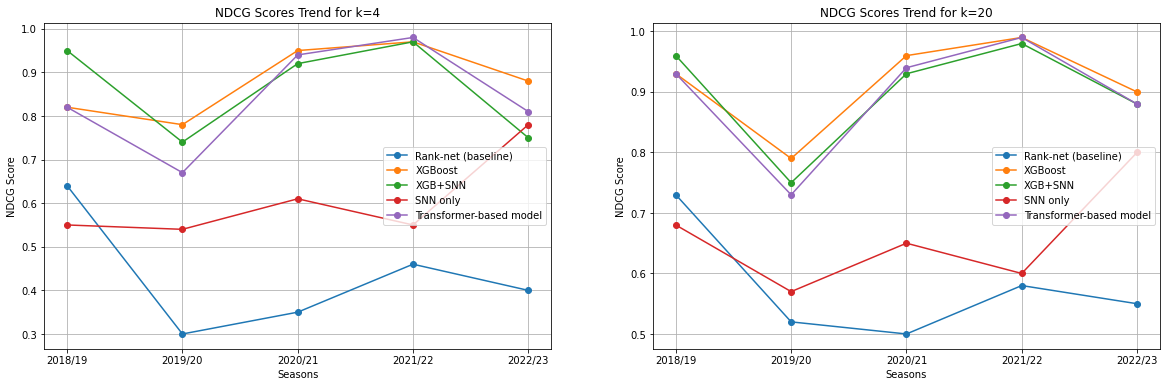

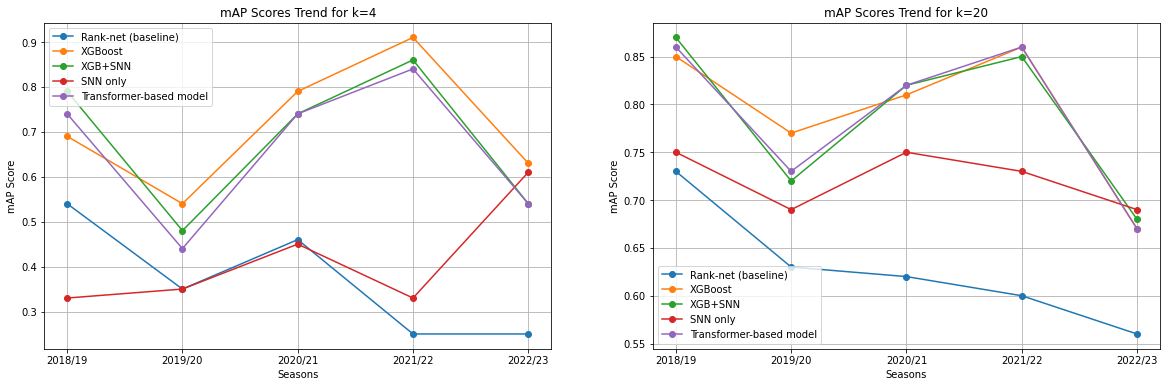

In [70]:
import matplotlib.pyplot as plt

# Data for the models and metrics
models = ['Rank-net (baseline)', 'XGBoost', 'XGB+SNN', 'SNN only', 'Transformer-based model']
seasons = ['2018/19', '2019/20', '2020/21', '2021/22', '2022/23']

# NDCG and mAP scores for k=5 and k=20
ndcg_k5 = [[0.64, 0.30, 0.35, 0.46, 0.40],
           [0.82, 0.78, 0.95, 0.97, 0.88],
           [0.95, 0.74, 0.92, 0.97, 0.75],
           [0.55, 0.54, 0.61, 0.55, 0.78],
           [0.82, 0.67, 0.94, 0.98, 0.81]]

map_k5 = [[0.54, 0.35, 0.46, 0.25, 0.25],
          [0.69, 0.54, 0.79, 0.91, 0.63],
          [0.79, 0.48, 0.74, 0.86, 0.54],
          [0.33, 0.35, 0.45, 0.33, 0.61],
          [0.74, 0.44, 0.74, 0.84, 0.54]]

ndcg_k20 = [[0.73, 0.52, 0.50, 0.58, 0.55],
            [0.93, 0.79, 0.96, 0.99, 0.90],
            [0.96, 0.75, 0.93, 0.98, 0.88],
            [0.68, 0.57, 0.65, 0.60, 0.80],
            [0.93, 0.73, 0.94, 0.99, 0.88]]

map_k20 = [[0.73, 0.63, 0.62, 0.60, 0.56],
           [0.85, 0.77, 0.81, 0.86, 0.67],
           [0.87, 0.72, 0.82, 0.85, 0.68],
           [0.75, 0.69, 0.75, 0.73, 0.69],
           [0.86, 0.73, 0.82, 0.86, 0.67]]

# Plotting function
def plot_trends_side_by_side(models, seasons, scores_k5, scores_k20, metric_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 2 columns

    # Plot k=5 scores
    for i, model in enumerate(models):
        ax1.plot(seasons, scores_k5[i], marker='o', label=model)
    ax1.set_title(f'{metric_name} Scores Trend for k=4')
    ax1.set_xlabel('Seasons')
    ax1.set_ylabel(f'{metric_name} Score')
    ax1.legend()
    ax1.grid(True)

    # Plot k=20 scores
    for i, model in enumerate(models):
        ax2.plot(seasons, scores_k20[i], marker='o', label=model)
    ax2.set_title(f'{metric_name} Scores Trend for k=20')
    ax2.set_xlabel('Seasons')
    ax2.set_ylabel(f'{metric_name} Score')
    ax2.legend()
    ax2.grid(True)

    plt.show()

# Plot NDCG scores side by side
plot_trends_side_by_side(models, seasons, ndcg_k5, ndcg_k20, 'NDCG')

# Plot mAP scores side by side
plot_trends_side_by_side(models, seasons, map_k5, map_k20, 'mAP')
